In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
from datetime import timedelta, datetime

In [3]:
ce5_log=pd.read_csv('./ce5.log',sep=" - ", header=None)


<ipython-input-3-ca636848d0fa>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ce5_log=pd.read_csv('./ce5.log',sep=" - ", header=None)


In [4]:
ce5_log.head()

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [5]:
ce5_log=ce5_log.rename(columns={0:'TIME', 1:'USER', 2:'RETRY', 3:'EXECUTION', 4: 'RETURNCODE', 5: 'COMMAND'})

In [6]:
ce5_log.head()

,TIME,USER,RETRY,EXECUTION,RETURNCODE,COMMAND
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [8]:
ce5_log['USER']=ce5_log['USER'].str.slice(start=5)

In [11]:
ce5_log['RETRY']=ce5_log['RETRY'].str.slice(start = 6)

In [14]:
ce5_log['EXECUTION']=ce5_log['EXECUTION'].str.slice(start = 5)

In [16]:
ce5_log['RETURNCODE']=ce5_log['RETURNCODE'].str.slice(start = 11)

In [62]:
ce5_log['EXECUTION']= ce5_log['EXECUTION'].astype(float)

In [17]:
ce5_log['USER'].unique()

array(['0', '9201', '9202', '9203', '9219', '9204', '9221', '112870'],
      dtype=object)

In [19]:
ce5_log['TIME']=pd.to_datetime(ce5_log['TIME'], format='%Y-%m-%dT%H:%M:%S')

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.

In [63]:
#Filter for sbatch command
sbatch=ce5_log[ce5_log['COMMAND'].str.contains('sbatch')]

In [64]:
#Get data for 9204
user_9204=sbatch[sbatch['USER'] == '9204']

In [67]:
#Filter for code 1
unresponsive=user_9204.loc[(user_9204['RETURNCODE']=='1') & (user_9204['EXECUTION'] > 15)]
# proportion of timeout jobs
unresponsive.shape[0]/user_9204.shape[0]

0.059558654257243396

In [69]:
unresponsive['EXECUTION'].describe()

count    1811.000000
mean       20.451334
std         2.705505
min        19.025584
25%        20.033827
50%        20.040414
75%        20.047409
max        43.075887
Name: EXECUTION, dtype: float64

In [83]:
unresponsive.head()

,TIME,USER,RETRY,EXECUTION,RETURNCODE,COMMAND
49958,2020-10-18 06:53:44.272915,9204,0,20.038464,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr..."
49972,2020-10-18 06:54:04.322412,9204,1,20.048906,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr..."
50467,2020-10-18 07:47:25.825172,9204,0,20.082628,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr..."
50473,2020-10-18 07:47:45.871008,9204,1,20.045221,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr..."
50582,2020-10-18 07:53:33.972840,9204,0,20.041486,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr..."


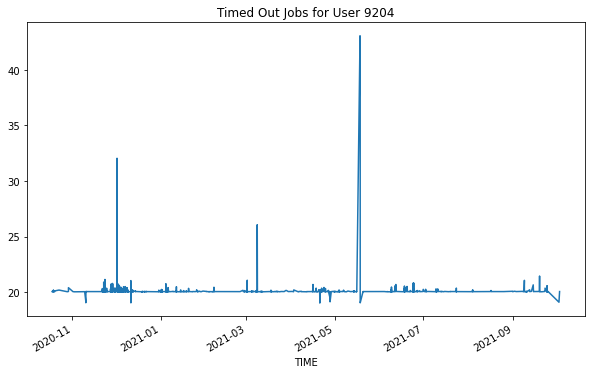

In [98]:
unresponsive[['TIME','EXECUTION']].set_index('TIME')['EXECUTION'].plot(figsize = (10,6))
plt.title('Timed Out Jobs for User 9204');

In [92]:
resp=user_9204.loc[(user_9204['RETURNCODE']=='0') & (user_9204['EXECUTION'] < 15)]

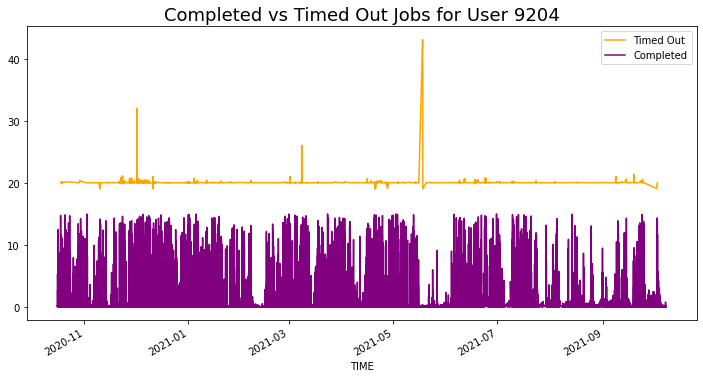

In [97]:
plt.figure(figsize = (12,6))
unresponsive[['TIME','EXECUTION']].set_index('TIME')['EXECUTION'].plot(color='orange', label ='Timed Out')
resp[['TIME','EXECUTION']].set_index('TIME')['EXECUTION'].plot(color='purple', label ='Completed')
plt.title('Completed vs Timed Out Jobs for User 9204', fontsize = 18)
plt.legend();

In [109]:
ce6=pd.read_csv('./ce6.log',sep=" - ", header=None, engine='python')

MemoryError: 